<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/03_PyMC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. PyMC3入門 (2)
* 今回、PyMC3を解説するに当たっては、PyMC3の公式サイトを参考にした。
 * https://docs.pymc.io/notebooks/api_quickstart.html

## 3.0 準備

### 3.0.1 インストール

In [1]:
!pip install arviz==0.10

     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 4.7MB 24.9MB/s 
     |████████████████████████████████| 768kB 28.5MB/s 
     |████████████████████████████████| 317kB 37.8MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


* バージョン3.9以上でないとできないことをするので、バージョンは3.9にする。

In [2]:
!pip install pymc3==3.9

     |████████████████████████████████| 1.9MB 5.2MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [51]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## 3.1 PyMC3におけるMCMC

### 3.1.0 MCMC（マルコフ連鎖モンテカルロ）とは
* ベイズ的なモデリングにおいて、事後分布を推論する方法の一つ。
 * もう一つは変分推論(variational inference)。
* MCMCは、事後分布からのサンプルを通して、事後分布そのものを知ろうとする方法。
 * サンプルは、いわば「点」。
 * 「点」をいくら集めても「面」にはならない。
 * しかし、「点」をたくさん集めることで「面」の全体像を知ろうとするのが、MCMC。
* モデルが複雑になるほど、事後分布$p(\theta|X)$からのサンプリングは、難しくなっていく。
 * 比較的シンプルなモデルについては、良いサンプリングができる（例：LDAのcollapsed Gibbs sampling）。
* この授業では、MCMCを実際に使う方法だけを説明する。理屈は説明しない。
 * 事後分布からのサンプリングは、一般にはとても難しい作業。

### 3.1.1 MCMCによる事後分布からのサンプリング

* PyMC3では、モデルを定義したら、関数`pm.sample()`を使えば、とりあえずは事後分布からのサンプルを得ることができる。

* 数値データがたくさんある。平均はゼロ付近だが、分からない。
* ベイズ的なモデリングによって、平均がいくらの可能性がどのくらい、という、事後分布を得たい。
 * 平均の一個の推定値（最尤推定やMAP推定の場合）ではなく、平均の分布が分かる。
* ここでは、下記のモデルを使う。
$$ \mu \sim N(0, 100) $$
$$ x \sim N(\mu, 1) $$
* このモデルをPyMC3で書くと、次のようになる。

In [4]:
model = pm.Model()

with model:
    mu = pm.Normal("mu", mu=0, sigma=100)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

* `mu`が従う事後分布からサンプルを得るには、以下のようにすればよい。
* `tune`は、最初の何個のサンプルを捨てるかを指定する引数。
 * MCMCで得られるサンプルは、最初のほうのものは、通常、捨てる。

In [5]:
with model:
    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 6 seconds.


* chainとは、サンプルの一つの系列のこと。
* MCMCによるサンプリングでは、直前のサンプルを少し変化させることで、次のサンプルを求める。
 * この変化のさせ方が賢いので、ちゃんと事後分布からのサンプルになる。（後で説明する。）
* ということは、サンプルは、初期値から始まって、一筋の系列をなしている。
* この系列をchainと呼ぶ。
* chainが一つだけだと心もとないので、普通は、複数のchainを走らせる。
* PyMC3のデフォルトの設定では、chainの数は、利用可能なコア数にしたがって自動的に決められる。

* 上のコードを実行すると、`idata`にサンプリング結果が保存されている。
* `idata.posterior`によって事後分布の情報にアクセスできる。

In [6]:
idata.posterior.dims

Frozen(SortedKeysDict({'chain': 2, 'draw': 2000}))

* サンプリングに使うcoreの数、生成するchainの数を指定する場合は、以下のようにする。

In [23]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [24]:
idata.posterior["mu"].shape

(4, 1000)

* 特定のchainだけ選ぶ方法は以下の通り。

In [25]:
idata.posterior["mu"].sel(chain=0).shape

(1000,)

In [26]:
idata.posterior["mu"].sel(chain=1)[:10]

<xarray.DataArray 'mu' (draw: 10)>
array([ 0.07787453,  0.2407198 ,  0.17323352,  0.28509218, -0.20077408,
        0.01475227, -0.03359029, -0.13364259, -0.03615803, -0.12970019])
Coordinates:
    chain    int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

* データ型はxarrayの配列。NumPyの配列とは違う。

In [27]:
type(idata.posterior["mu"])

xarray.core.dataarray.DataArray

* `.data`でndarrayへ変換できる。

In [28]:
type(idata.posterior["mu"].data)

numpy.ndarray

In [29]:
idata.posterior["mu"].data.shape

(4, 1000)

* サンプルのヒストグラムを描くと、事後分布の大体の形が分かる。

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

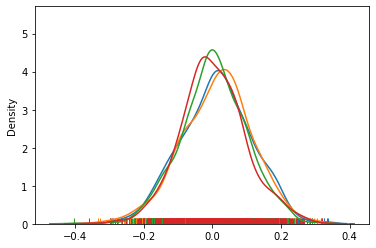

In [45]:
import seaborn as sns

for i in range(idata.posterior["mu"].data.shape[0]):
    sns.distplot(idata.posterior["mu"].data[i], rug=True, hist=False)

* さて、chainが４本からなるこのサンプルは、うまく事後分布を表しているのだろうか？

## 3.2 サンプリング結果の分析

### 3.2.0 MCMCのツールが与えるサンプルを鵜呑みにしない
* MCMCを使うときには、サンプルが良いサンプルか悪いサンプルかを、気にしないといけない。
* 得られたサンプルが、本当に事後分布からのサンプルと見なせるのか、分析して評価する必要がある。
* 分析の結果によっては、確率変数によって別々のサンプリング手法を使う必要すらあるかもしれない。

### 3.2.1 PyMC3で使えるサンプリング手法

* PyMC3のドキュメントには、以下のように書いてある。
"For almost all continuous models, ``NUTS`` should be preferred."
* ``NUTS``では良いサンプルが得られない場合、``Metropolis``を使う人が多いが、これは良くない選択だ、とも書いてある。
* ``NUTS``でうまくいかない時は、初期値を変えるか、変数変換をするのが良い。
* Metropolis法では、effective sample sizeが小さくなってしまうことが多い。
 * つまり、$x^{new}$が新しい値に更新されないことが多い。

In [14]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

* メトロポリス法を使ってみる。

In [15]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Sequential sampling (2 chains in 1 job)
Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


* 今度は標準偏差パラメータにも事前分布を導入し・・・
* 平均パラメータと標準偏差パラメータとで、サンプリング手法を変えてみる。

In [56]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.
The number of effective samples is smaller than 25% for some parameters.


### 3.2.2 サンプルの分析

* arvizでサンプルを可視化する。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48535dddd0>,
      dtype=object)

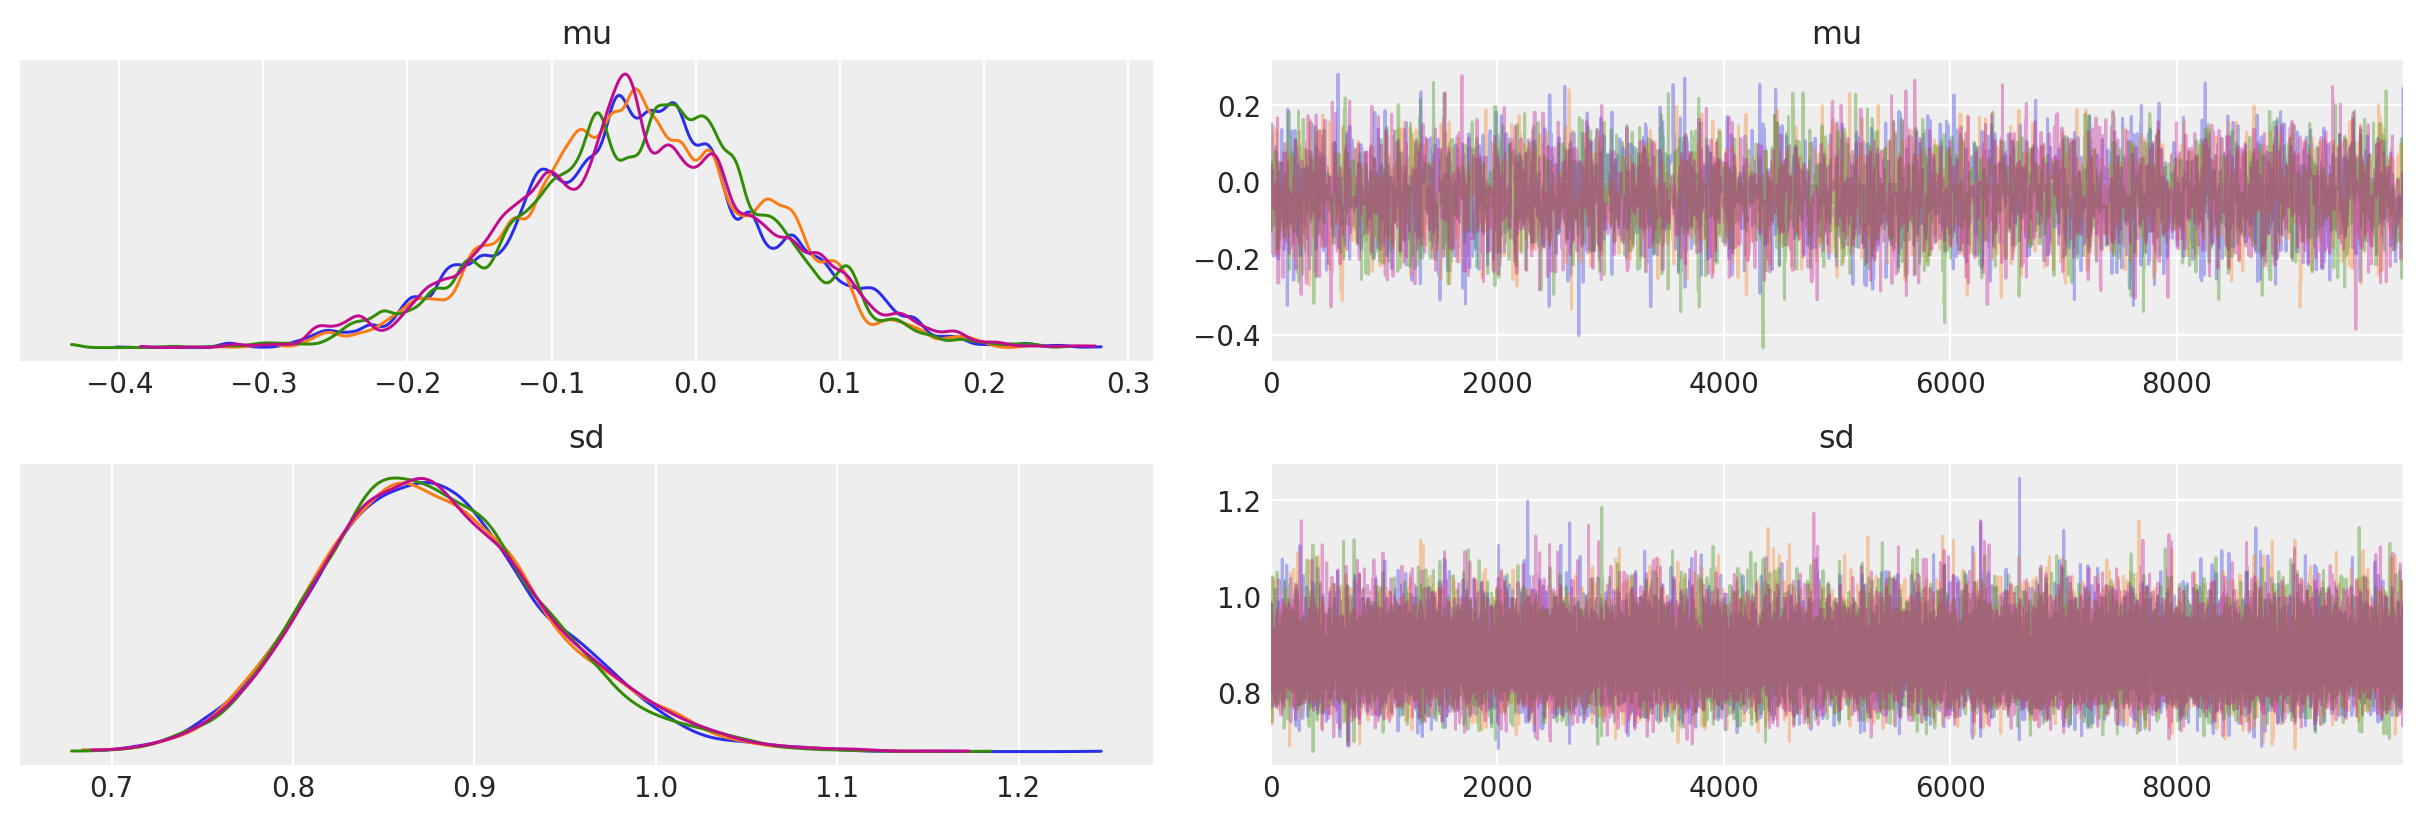

In [57]:
az.plot_trace(idata)

* Gelman-Rubin統計量
 * 定量的にサンプルの良し悪しを分析。
 * R-hatと呼ばれる値が1に近いほど、連鎖の分布がより収束している。
 * http://www.omori.e.u-tokyo.ac.jp/MCMC/mcmc.pdf の6.2.2を参照。

In [58]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.038,0.088,-0.205,0.127,0.001,0.001,5473.0,4725.0,5470.0,5385.0,1.0
sd,0.877,0.063,0.765,1.000,0.000,0.000,35632.0,35269.0,36200.0,27191.0,1.0


 * arvizによる他の可視化。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4853818550>,
      dtype=object)

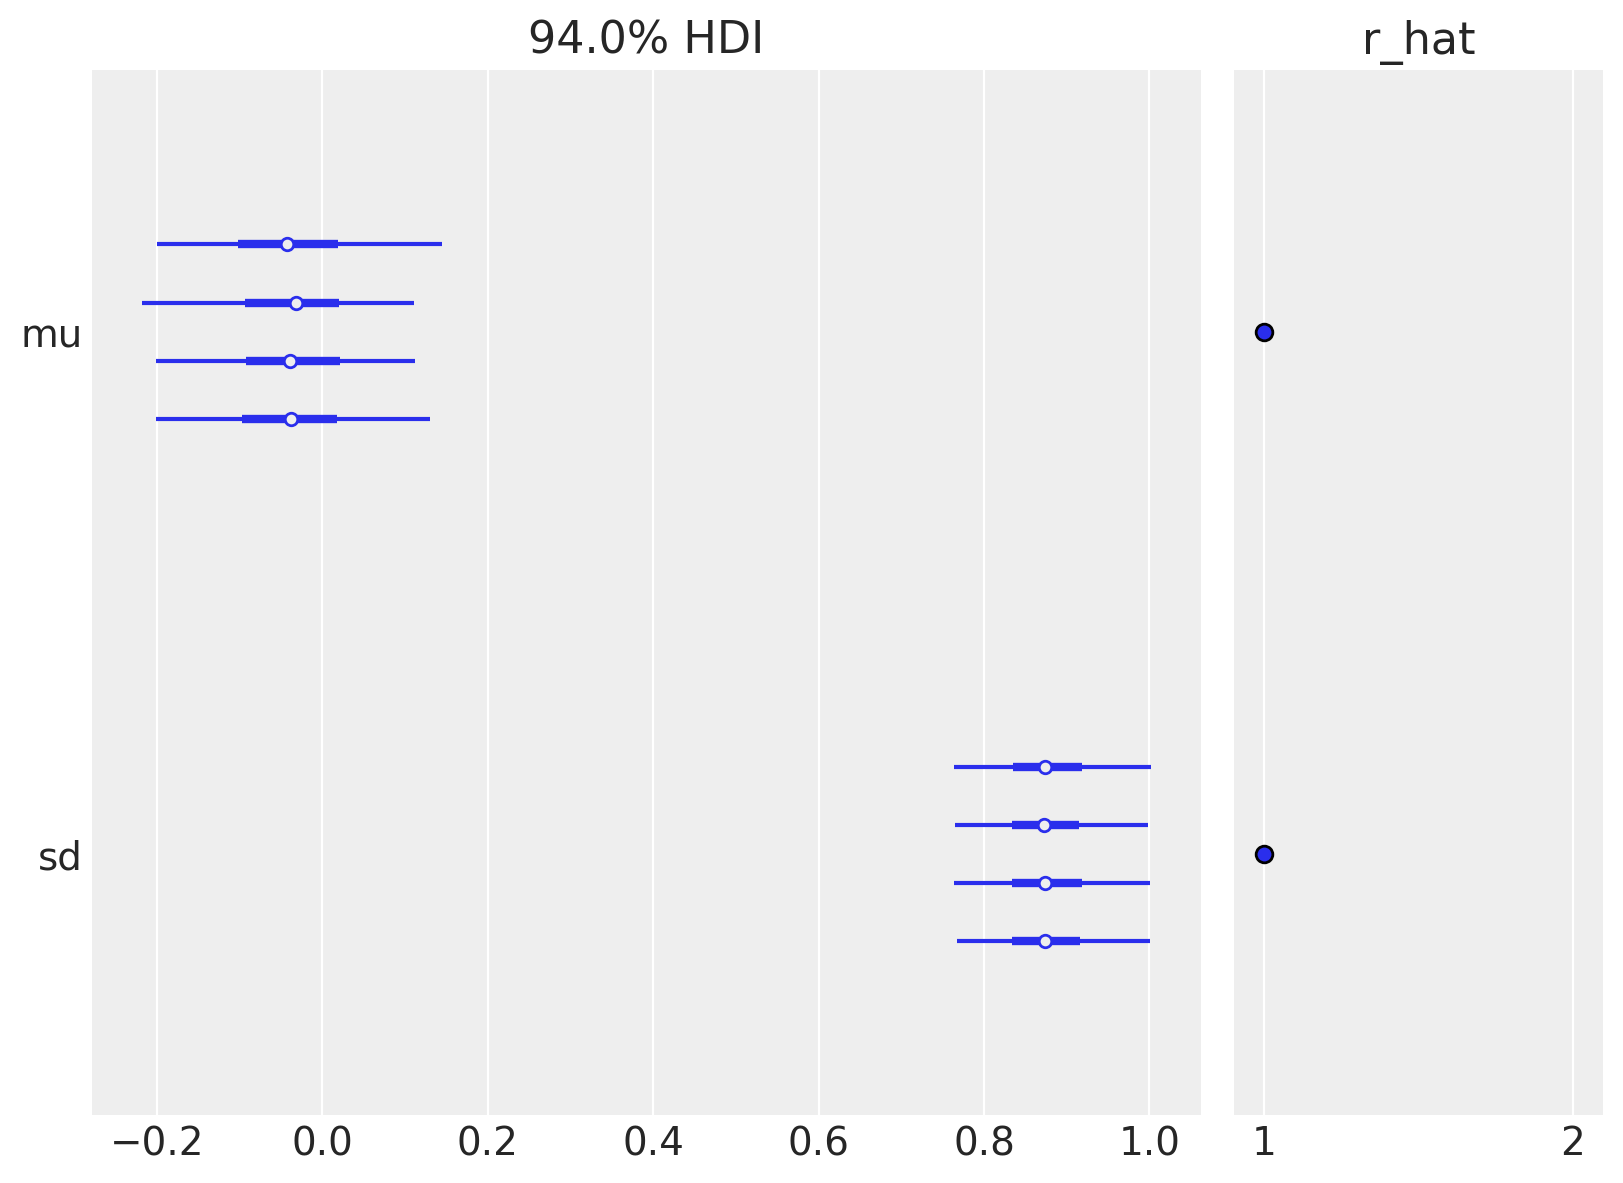

In [59]:
az.plot_forest(idata, r_hat=True)

* さらに別の可視化。
 * https://sites.google.com/site/doingbayesiandataanalysis/ この本の流儀による可視化だそうです（がよく知りません・・・）。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48666034d0>,
      dtype=object)

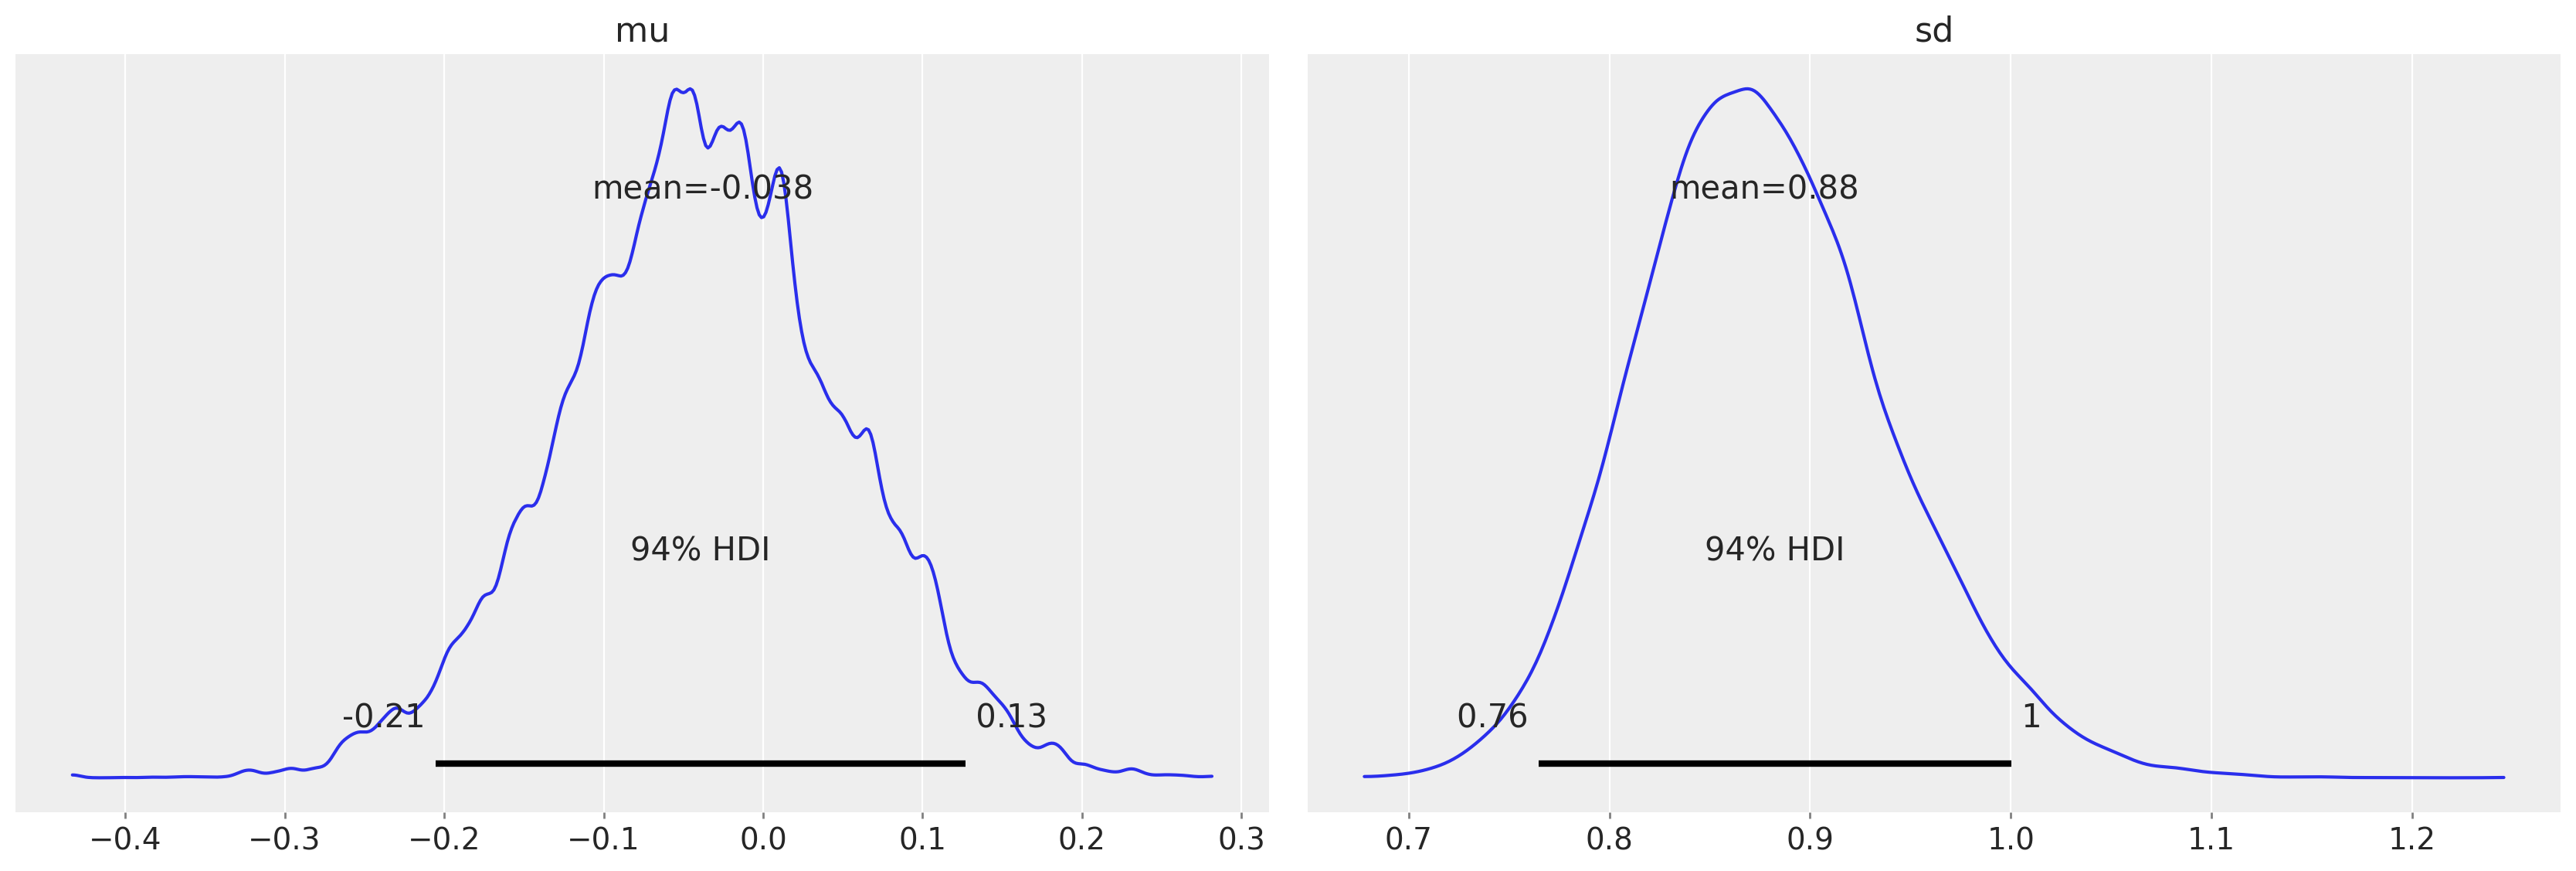

In [60]:
az.plot_posterior(idata)

In [62]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step = pm.Metropolis()
    idata = pm.sample(10000, step=step, cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f486156b2d0>,
      dtype=object)

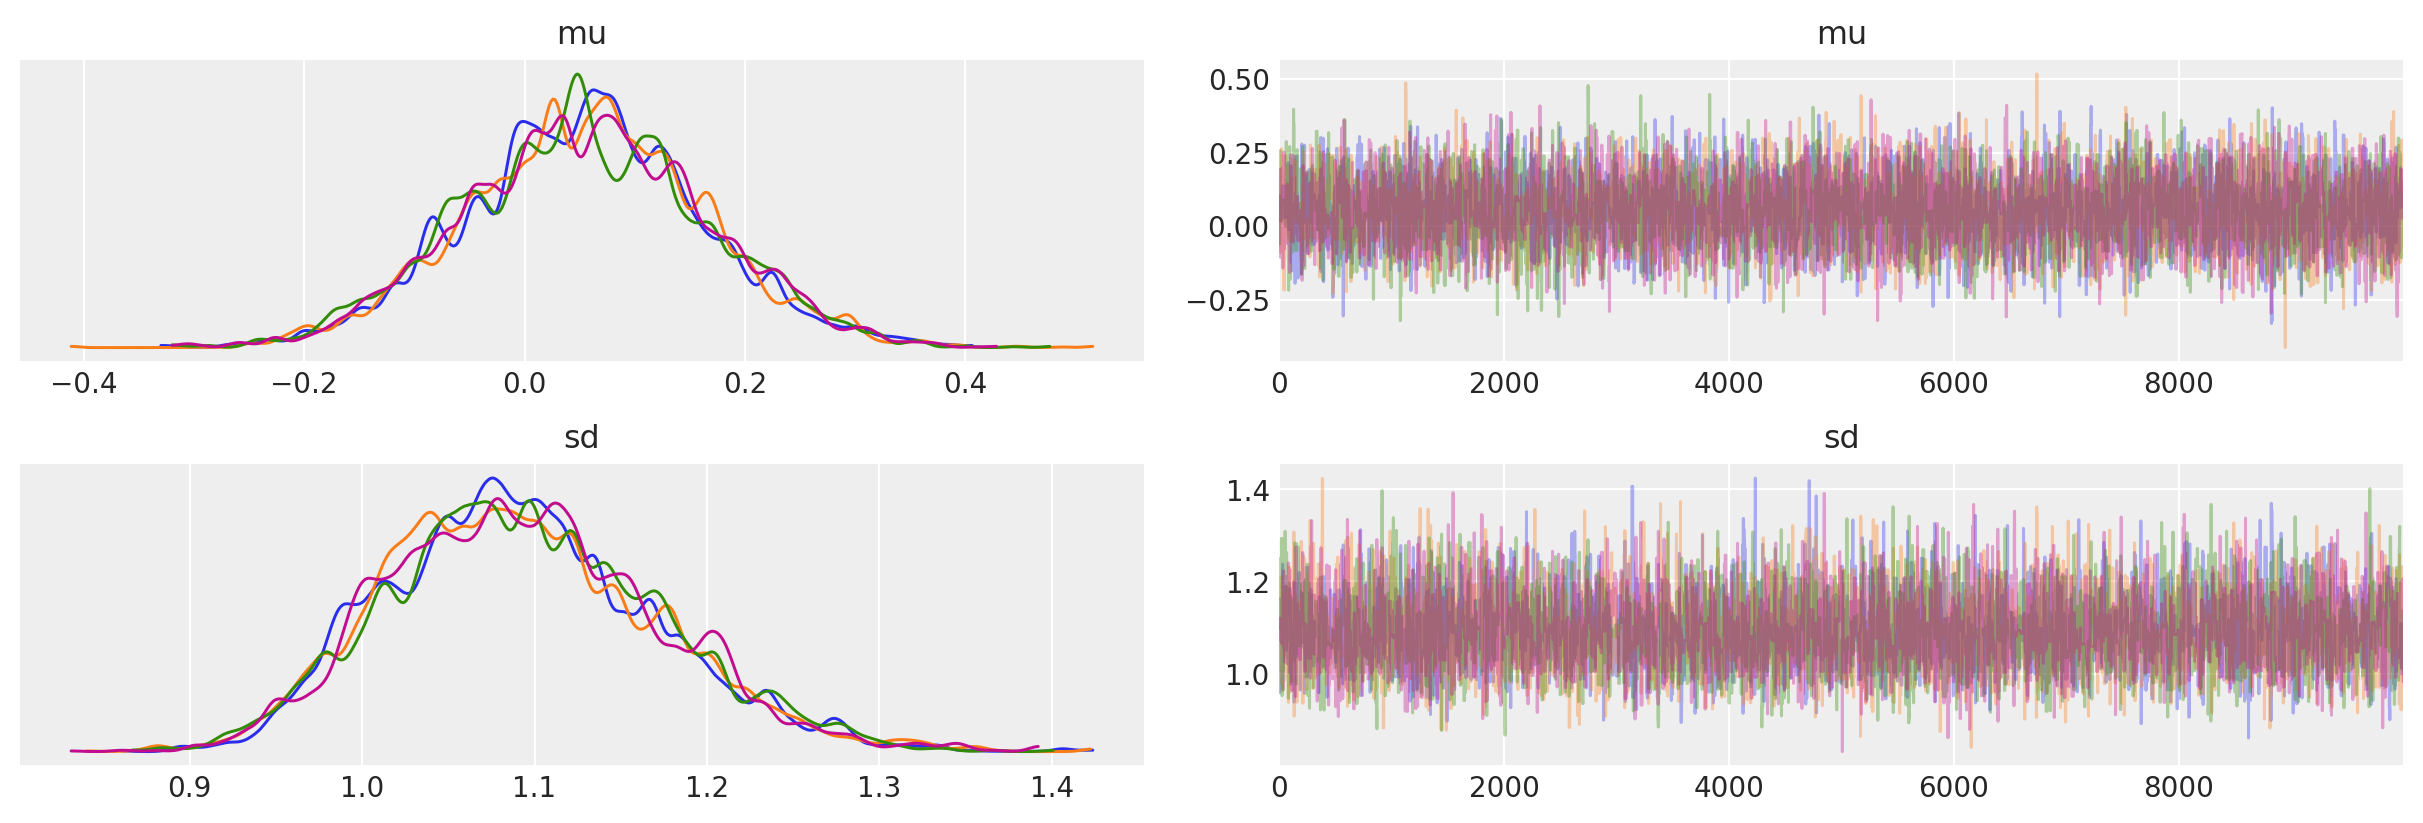

In [63]:
az.plot_trace(idata)

In [64]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    idata = pm.sample(10000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 44 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f486099fc90>,
      dtype=object)

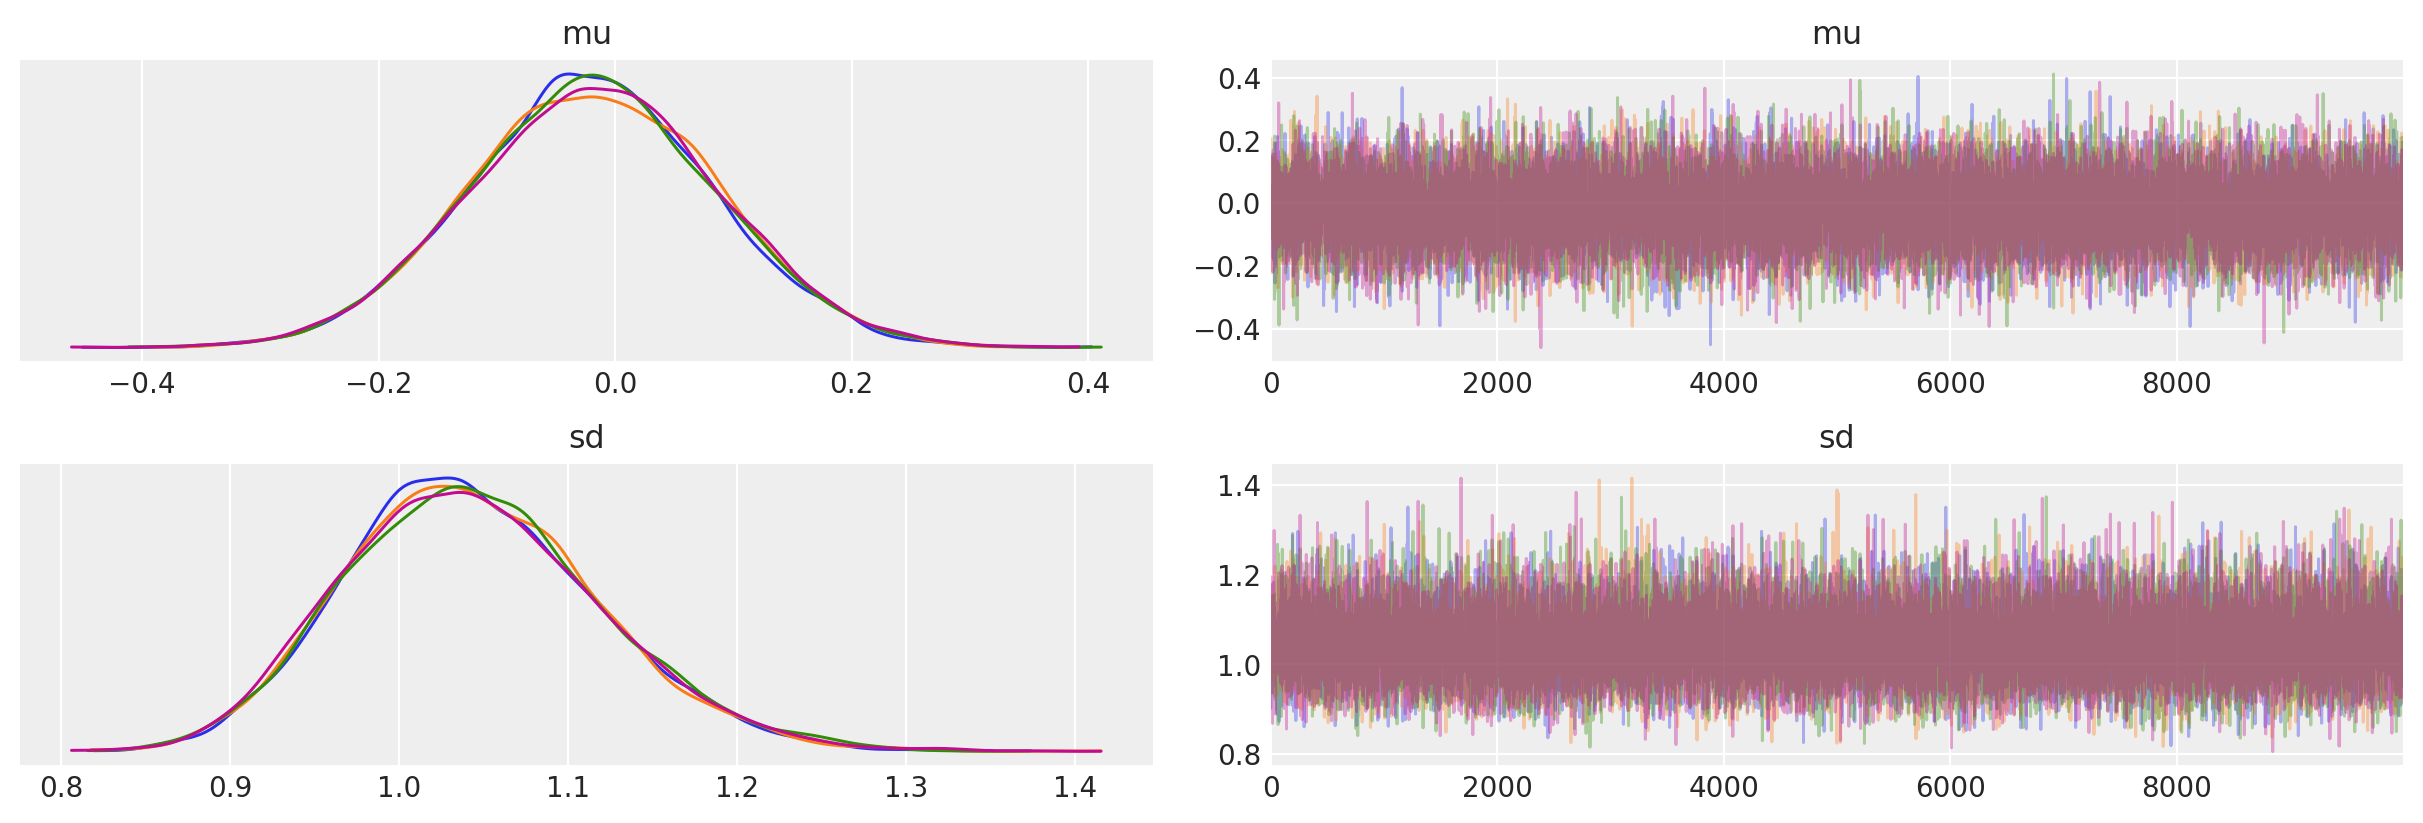

In [65]:
az.plot_trace(idata)

* 事後分布がheavy tailedな分布だった場合、Markov chainがその重たい裾野を十分に踏査していない可能性がある。
* これを調べるために、marginal energy
 * https://arxiv.org/abs/1701.02434 の6.1を参照。

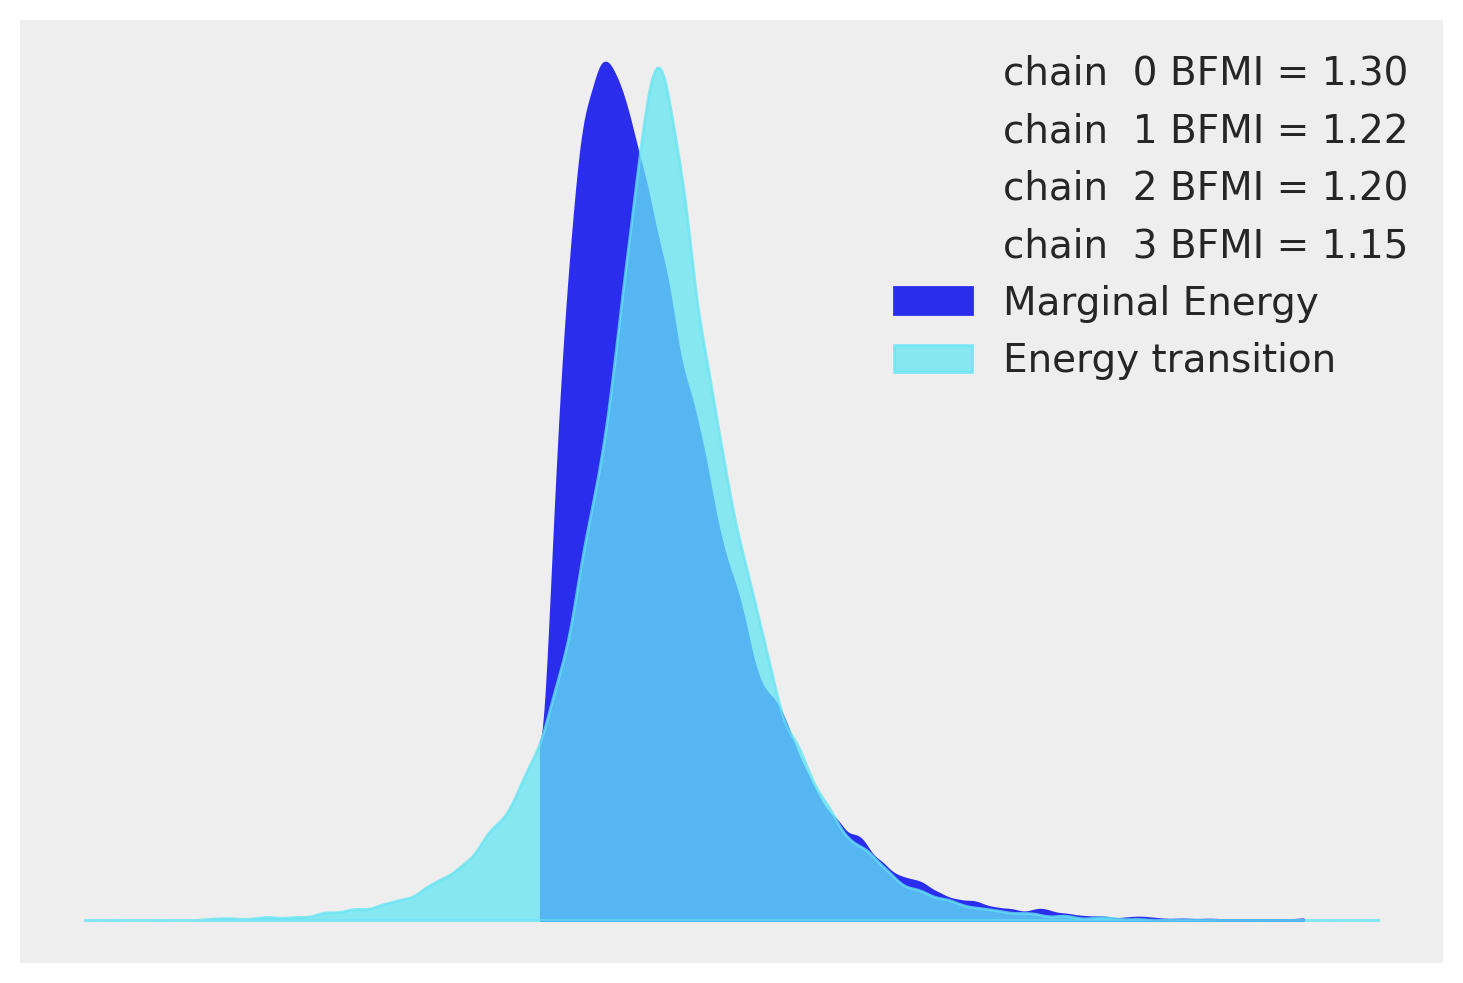

In [66]:
az.plot_energy(idata)

### 2.3.3 変分推論